In [1]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box, MultiLineString
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box, LineString, mapping
from rasterio.features import shapes
import osmnx as ox
import os
from tqdm import tqdm
import dask
from dask import delayed, compute
import dask.bag as db
from rasterio.mask import mask


# conda install adlfs

c:\Users\reube\anaconda3\envs\papermillonly\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
latlng = (lat, lng)

In [4]:
if not os.path.exists(f'./output/{place}'):
    os.makedirs(f'./output/{place}')

## part 1: Find limits of cells to download

In [5]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'
    
# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
square = create_square(center_point, radius * 1000)  # Convert km to meters

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(crs)

# Plotting
area_of_interest.explore()

In [6]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



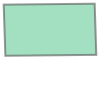

In [7]:
area_of_interest.iloc[0]

In [8]:
proj_string = "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

area_of_interest_54009 = area_of_interest.to_crs(proj_string)

In [15]:

# Function to get a polygon representing a raster cell
def get_cell_polygon(x, y, transform):
    return Polygon([
        transform * (x, y), 
        transform * (x + 1, y), 
        transform * (x + 1, y + 1), 
        transform * (x, y + 1), 
        transform * (x, y)
    ])

# Initialize an empty dictionary to hold feature data
feature_dict = {}

# Specify the path and name of the raster file
raster_name = "GHS_BUILT_H_100"

# Load the raster file
with rasterio.open(f"input/gitignore/ghsl/{raster_name}.tif") as src:
    
    # Ensure the area_of_interest_54009 is defined and in the correct CRS
    # (This might require reprojecting the area_of_interest_54009 or the raster)
    
    # Crop the raster with the area of interest
    out_image, out_transform = mask(src, area_of_interest_54009.geometry, crop=True)
    
    # Copy and update the metadata from the source raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Define the output path for the cropped raster
    output_path = f"output/{place}/{raster_name}_cropped.tif"
    
    # Write out the cropped raster to file
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)
        
        # Iterate over the raster's pixels and record non-zero values
        for row in range(out_image.shape[1]):
            for col in range(out_image.shape[2]):
                value = out_image[0, row, col]  # Assuming first band
                if value:  # Process only non-zero (or non-background) values
                    polygon = get_cell_polygon(col, row, out_transform)
                    key = (row, col)
                    
                    # Create or update the feature dictionary
                    if key not in feature_dict:
                        feature_dict[key] = {'row': row, 'col': col, 'geometry': polygon, raster_name: int(value)}
                    else:
                        feature_dict[key][raster_name] = int(value)

features = []
for feature in feature_dict.values():
    features.append(feature)

# Create a GeoDataFrame
raster_data = gpd.GeoDataFrame(features)

# Set the geometry column explicitly
raster_data.set_geometry('geometry', inplace=True)

raster_data.crs = "ESRI:54009"
raster_data_4326 = raster_data.to_crs("EPSG:4326")


In [17]:
def concat_raster(raster_data_4326, raster_name):
    # Function to get a polygon representing a raster cell
    def get_cell_polygon(x, y, transform):
        return Polygon([
            transform * (x, y), 
            transform * (x + 1, y), 
            transform * (x + 1, y + 1), 
            transform * (x, y + 1), 
            transform * (x, y)
        ])

    # Initialize an empty dictionary to hold feature data
    feature_dict = {}

    # Load the raster file
    with rasterio.open(f"input/gitignore/ghsl/{raster_name}.tif") as src:
        
        # Ensure the area_of_interest_54009 is defined and in the correct CRS
        # (This might require reprojecting the area_of_interest_54009 or the raster)
        
        # Crop the raster with the area of interest
        out_image, out_transform = mask(src, area_of_interest_54009.geometry, crop=True)
        
        # Copy and update the metadata from the source raster
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Define the output path for the cropped raster
        output_path = f"output/{place}/{raster_name}_cropped.tif"
        
        # Write out the cropped raster to file
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
            
            # Iterate over the raster's pixels and record non-zero values
            for row in range(out_image.shape[1]):
                for col in range(out_image.shape[2]):
                    value = out_image[0, row, col]  # Assuming first band
                    if value:  # Process only non-zero (or non-background) values
                        polygon = get_cell_polygon(col, row, out_transform)
                        key = (row, col)
                        
                        # Create or update the feature dictionary
                        if key not in feature_dict:
                            feature_dict[key] = {'row': row, 'col': col, 'geometry': polygon, raster_name: int(value)}
                        else:
                            feature_dict[key][raster_name] = int(value)
                            
    features = []
    for feature in feature_dict.values():
        features.append(feature)

        # Create a GeoDataFrame
    out_data = gpd.GeoDataFrame(features)

    # Set the geometry column explicitly
    out_data.set_geometry('geometry', inplace=True)
        
        
    out_data.crs = "ESRI:54009"
    out_data_4326 = out_data.to_crs("EPSG:4326")
    
    raster_data_4326.explore()  

    return raster_data_4326.sjoin(out_data_4326[[raster_name, "geometry"]], how="left", predicate='within').drop(columns=["index_right"], axis=1)

In [18]:
for entry in tqdm(["GHS_BUILT_S_100", "GHS_BUILT_V_100", "GHS_LAND_100", "GHS_POP_100"]):
    
    raster_data_4326 = concat_raster(raster_data_4326, entry)

100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


In [19]:
raster_data_4326.explore() 

In [ ]:
collated_gdf = raster_data_4326

In [ ]:
collated_gdf

In [ ]:
collated_gdf.explore()

In [ ]:
drop_values = {
    "GHS_BUILT_H_100": 255,
    "GHS_LAND_100": 65535,
    'GHS_BUILT_V_100': 4294967295,
    'GHS_POP_100': -200,
    'GHS_BUILT_S_100': 65535,
}

# Create a boolean series that represents rows to drop
# Start with a series of all False (meaning keep all initially)
rows_to_drop = pd.Series([False] * len(collated_gdf))

# Update the series to True for rows that meet the drop conditions
for column, value in drop_values.items():
    rows_to_drop = rows_to_drop | (collated_gdf[column] == value)

# Drop the rows from the GeoDataFrame where any of the conditions are True
collated_gdf = collated_gdf[~rows_to_drop]

In [ ]:
collated_gdf.columns = [col.replace('aligned_', '') if col.startswith('aligned_') else col for col in collated_gdf.columns]


In [ ]:
collated_gdf = collated_gdf.set_crs(4326)

In [ ]:
collated_gdf.to_parquet(f"output/{place}/raster_data.pq")

# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [ ]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius+5) * 1000)  # Convert km to meters

buffer = buffer_circle

# Reproject buffer back to original CRS
buffer = buffer.to_crs(crs)

# Plotting
buffer.explore()


In [ ]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [ ]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [ ]:
# selected_features_union.plot()

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [ ]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

In [ ]:
if country == None:
    world_poly = gpd.read_file(f"input/{place}_study_area.shp")
else:
    world_poly = gpd.read_file(f"input/{country}_study_area.shp")

In [ ]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

In [ ]:
buffer = gpd.GeoDataFrame(geometry=buffer)

In [ ]:
water_gdf = water_gdf.reset_index(drop=True)

In [ ]:
world_poly

In [ ]:
buffer = world_poly.overlay(buffer, how='intersection').overlay(water_gdf, how='difference')

In [ ]:
buffer

In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in buffer.columns if col != 'geometry']

# Drop these columns
buffer = buffer.drop(columns=columns_to_drop)

In [ ]:
buffer_new = buffer.dissolve()

In [ ]:
buffer_new.to_parquet(f"./output/{place}/study_area.pq")

In [ ]:
buffer_new.plot()

In [ ]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='drive', truncate_by_edge=True, retain_all=True)
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

streets.head()

In [ ]:
streets.plot()

In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [ ]:
# Assuming your GeoDataFrame is named 'gdf'
line_strings = []
for geometry in streets.geometry:
    if geometry.geom_type == 'LineString':
        line_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        line_strings.extend(list(geometry))

In [ ]:
collection = shapely.GeometryCollection(line_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
streets_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [ ]:
# Assuming streets is your existing GeoDataFrame

# Function to break apart MultiLineStrings
def explode_multilinestring(multilinestring):
    if isinstance(multilinestring, MultiLineString):
        return list(multilinestring)
    else:
        return [multilinestring]

# Explode all MultiLineStrings into individual LineStrings
exploded_lines = [explode_multilinestring(geom) for geom in streets.geometry]

# Flatten the list of lists into a single list of geometries
flat_list = [item for sublist in exploded_lines for item in sublist]

# Create a new GeoDataFrame
streets_noded_gdf = gpd.GeoDataFrame(geometry=flat_list)

In [ ]:
streets_noded_gdf.plot()

In [ ]:
streets_noded_gdf = streets_noded_gdf.set_crs(local_crs)

In [ ]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()



In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

In [ ]:
# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))

In [ ]:
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [ ]:
rail_noded_gdf.plot()

In [ ]:
buildings

In [ ]:
buildings = buildings[["geometry"]]

In [ ]:
buildings = gpd.sjoin(buildings, buffer_new, how="left", op="within")

In [ ]:
buildings = buildings[buildings["index_right"] == 0][["geometry"]]

In [ ]:
buildings.to_parquet(f"./output/{place}/buildings_raw.pq")

streets_noded_gdf.to_parquet(f"./output/{place}/streets_raw.pq")

rail_noded_gdf.to_parquet(f"./output/{place}/rail_raw.pq")

In [ ]:
water_gdf.plot()

In [ ]:
water_gdf.to_parquet(f"./output/{place}/water.pq")